In [91]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import random
from timeit import default_timer as timer
random.seed(1000)

$min_xf(\mathbf{x}) = \frac {1}{2}{||Ax-y||}^2_2 + \frac{\lambda}{2} x^T x 
\quad$

Our objective is to minimize this loss function which is the ordinary least square with regularisation.

$\large\textbf{Part 1 : Regularization}$ 

*The parameter $\lambda$ in the function, $f(x)$ is regularisation or tuning parameters which acts as a tool so that the value of weight in the regression model(x here) also have a cost. So if the value of $\lambda$ is very large then it means there is a huge cost associated with increasing the value of x, so when $\lambda$ is large, the weights are shrinked so that our overall cost, $f(x)$ is minimised. When $\lambda$ is very low or even 0 then it doesnt matter much even if the vector x takes large value, the panelty then is very low. When $\lambda$ =0, it becomes the original least square loss function.* 

### $\textbf{General Code}$

In [92]:
def evalf(A,x,y,n_feat, n, lamb):
  assert type(A) is np.ndarray and A.shape == (n, n_feat)
  assert type(x) is np.ndarray and x.shape == (n_feat,1)
  assert type(y) is np.ndarray and y.shape == (n,1)
  assert type(n_feat) is int and n_feat >0
  assert type(n) is int and n >0
  assert lamb > 0 

  f = np.matmul(A,x) - y

  return 0.5*(np.linalg.norm(f))**2  + 0.5*lamb*(np.matmul(x.T , x))


def evalg(A,x,y,n_feat, n, lamb):
  assert type(A) is np.ndarray and A.shape == (n, n_feat)
  assert type(x) is np.ndarray and x.shape == (n_feat,1)
  assert type(y) is np.ndarray and y.shape == (n,1)
  assert type(n_feat) is int and n_feat >0
  assert type(n) is int and n >0
  assert lamb > 0

  d = np.matmul(A,x) - y
  g = np.matmul(A.T , d) + lamb*x

  return g



def evalh(A,x,y,n_feat, n, lamb):
  assert type(A) is np.ndarray and A.shape == (n, n_feat)
  assert type(x) is np.ndarray and x.shape == (n_feat,1)
  assert type(y) is np.ndarray and y.shape == (n,1)
  assert type(n_feat) is int and n_feat >0
  assert type(n) is int and n >0

  h = np.matmul(A.T , A) + lamb*np.identity(n_feat)

  return h


In [93]:
def compute_steplength_backtracking_scaled_direction(A,x,y, n_feat, n ,lamb  ,gradf, direction, alpha_start, rho, gamma): #add appropriate arguments to the function 
  assert type(x) is np.ndarray and x.shape == (n_feat,1)
  assert type(gradf) is np.ndarray and gradf.shape == (n_feat,1)
  assert type(direction) is np.ndarray and direction.shape == (n_feat, n_feat)
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 

  alpha = alpha_start
  p = -gradf

  while (evalf(A, x + alpha*np.matmul(direction,p), y, n_feat, n,lamb) > (evalf(A,x,y,n_feat,n,lamb) + gamma * alpha * np.matmul(gradf.T, np.matmul(direction, p))) ):
    alpha = alpha*rho
 
  return alpha


#line search type 
CONSTANT_STEP_LENGTH = 3
BACKTRACKING_LINE_SEARCH = 2
EXACT_LINE_SEARCH = 1



def find_minimizer_Newtonmethod(A, start_x, y, n_feat,  n,lamb, tol, line_search_type, *args):
  #Input: start_x is a numpy array of size n, tol denotes the tolerance and is a positive float value
  assert type(A) is np.ndarray and A.shape == (n, n_feat)
  assert type(start_x) is np.ndarray and start_x.shape == (n_feat,1)
  assert type(y) is np.ndarray and y.shape == (n,1)
  assert type(n_feat) is int and n_feat >0
  assert type(n) is int and n >0
  assert type(tol) is float and tol>=0 
  
  x = start_x
  g_x = evalg(A,x,y,n_feat,n,lamb)
  

  if line_search_type == BACKTRACKING_LINE_SEARCH:
    if args is None:
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
      raise ValueError(err_msg)
    elif len(args)<3 :
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
      raise ValueError(err_msg)
    else:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])
  k = 0
  x_k = []
  
  #print('iter:',k,  ' f(x):', evalf(x,n), ' gradient norm:', np.linalg.norm(g_x))

  while (np.linalg.norm(g_x) > tol):

    d = np.linalg.inv(evalh(A,x,y,n_feat,n,lamb))

    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(A,x,y,n_feat,n,lamb,g_x, d , alpha_start,rho, gamma)
 
    elif line_search_type == CONSTANT_STEP_LENGTH: 
      step_length = 1.0
 
    else:  
      raise ValueError('Line search type unknown. Please check!')
 
    x = np.subtract(x, step_length * np.matmul(d,g_x)) 
    k += 1 
    x_k.append(x)
    g_x = evalg(A,x,y,n_feat,n,lamb)
  
  return x, k, x_k



def find_minimizer_BFGS(A, start_x, y, n_feat, n,lamb, tol,line_search_type,*args):
  assert type(A) is np.ndarray and A.shape == (n, n_feat)
  assert type(start_x) is np.ndarray and start_x.shape == (n_feat,1)
  assert type(y) is np.ndarray and y.shape == (n,1)
  assert type(n_feat) is int and n_feat >0
  assert type(n) is int and n >0
  assert type(tol) is float and tol>=0 


  x = start_x
  k = 0
  g_new = evalg(A,x,y,n_feat,n,lamb)
  B = np.identity(n_feat)
  x_k = []  

  if line_search_type == BACKTRACKING_LINE_SEARCH:
    if args is None:
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
      raise ValueError(err_msg)
    elif len(args)<3 :
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
      raise ValueError(err_msg)
    else:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])

  while (np.linalg.norm(g_new) > tol):

    d = B

    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(A,x,y,n_feat,n,lamb ,g_new, d , alpha_start,rho, gamma)
 
    elif line_search_type == CONSTANT_STEP_LENGTH: 
      step_length = 1.0
 
    else:  
      raise ValueError('Line search type unknown. Please check!')
      
    g_old = evalg(A,x,y,n_feat,n,lamb)
    p = np.matmul(-1*B, g_old)
    x = x + step_length * p
    s = step_length * p
    g_new = evalg(A,x,y,n_feat,n,lamb)
    y_k = g_new - g_old

    mu = 1 / (np.matmul(y_k.T,s))
    term1 = np.identity(n_feat) - mu * np.matmul(s,y_k.T)
    term2 = np.identity(n_feat) - mu * np.matmul(y_k, s.T)

    B = np.matmul(term1, np.matmul(B ,term2))  +  mu * np.matmul(s,s.T)
    
    k = k + 1
    x_k.append(x)
    

  return x, k, x_k



### $\textbf{Data Prep.}$

In [94]:
p = 2
n_sample = 800

A = random.randn(n_sample, p)
x_bar = np.zeros((p,1))

x_bar[0] = random.uniform(-4.0, -2.0)
x_bar[1] = random.uniform(6.0, 8.0)

e = random.rand(n_sample, 1)
y = np.matmul(A,x_bar) + e



### $\textbf{Part 3 : Solving by Newton's and BFGS method }$

$\lambda = 1$

$x_0 = (0,0), \ \ \ x_0= (50,50), \ \ \ x_0= (-5,-5)$

*Calculating the optimal value from different methods and plotiing the graph with respect to the number of iteration and and value of x at that iteration in both the methods*

In [95]:
my_x = [np.array([0,0]).reshape((2, 1)) , np.array([50,50]).reshape((2, 1)) , np.array([-5,-5]).reshape((2, 1))]
my_tol = 10e-5
alpha = 0.9
rho = 0.5
gamma = 0.5
lamb = 1.0

x_nwtn = []
x_bfgs= []
x_iterates_nwtn = []
x_iterates_bfgs = []

for x in my_x:
  a_n, b_n, c_n  = find_minimizer_Newtonmethod(A,x,y,p,n_sample,lamb,my_tol,BACKTRACKING_LINE_SEARCH,alpha,rho,gamma)
  x_nwtn.append(a_n.reshape((p,1)))
  x_iterates_nwtn.append(c_n)

  a_b, b_b, c_b = find_minimizer_BFGS(A,x,y,p,n_sample,lamb,my_tol,BACKTRACKING_LINE_SEARCH,alpha,rho,gamma)
  x_bfgs.append(a_b.reshape((p,1)))
  x_iterates_bfgs.append(c_b)





In [96]:
dic = {'Starting X' : my_x , 'x_bar' : [x_bar, x_bar, x_bar],'X_optimal_Nwtn' : x_nwtn , 'F(x)_optimal_Nwtn' : [evalf(A,x,y,p,n_sample,lamb) for x in x_nwtn] , 'Iterations_Nwtn' : [len(x_iterates_nwtn[j]) for j in range(len(my_x))] }
df = pd.DataFrame(dic)
display(df)

print('\n\n')

dic2 = {'Starting X' : my_x , 'x_bar' : [x_bar, x_bar, x_bar],'X_optimal_bfgs' : x_bfgs , 'F(x)_optimal_bfgs' : [evalf(A,x,y,p,n_sample,lamb) for x in x_bfgs] , 'Iterations_bfgs' : [len(x_iterates_bfgs[j]) for j in range(len(my_x))] }
df2 = pd.DataFrame(dic2)
df2




,Starting X,x_bar,X_optimal_Nwtn,F(x)_optimal_Nwtn,Iterations_Nwtn
0,"[[0], [0]]","[[-3.7764178534330535], [7.17359240073729]]","[[-3.7643235563275175], [7.157234396564945]]",[[165.05367424217013]],8
1,"[[50], [50]]","[[-3.7764178534330535], [7.17359240073729]]","[[-3.7643235402064295], [7.1572345109800555]]",[[165.05367424216948]],9
2,"[[-5], [-5]]","[[-3.7764178534330535], [7.17359240073729]]","[[-3.7643235952064296], [7.157234455980055]]",[[165.05367424216757]],9


,Starting X,x_bar,X_optimal_bfgs,F(x)_optimal_bfgs,Iterations_bfgs
0,"[[0], [0]]","[[-3.7764178534330535], [7.17359240073729]]","[[-3.764323546012924], [7.157234375909245]]",[[165.05367424217184]],10
1,"[[50], [50]]","[[-3.7764178534330535], [7.17359240073729]]","[[-3.764323564325008], [7.157234491095188]]",[[165.05367424216806]],11
2,"[[-5], [-5]]","[[-3.7764178534330535], [7.17359240073729]]","[[-3.7643235952385234], [7.157234454059211]]",[[165.05367424216757]],11


***Remarks :***  *We observe that the number of iterations taken by BFGS method to calculate the optimal value of x is more than that compared to the newtons method. Altough on comparing the values to the original value of x_bar we notice that our algorithm is very correct in calculating the true value of the paramer x_bar. Hence both methods are accurate in calculating the value but newtons method can achieve the task faster*

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


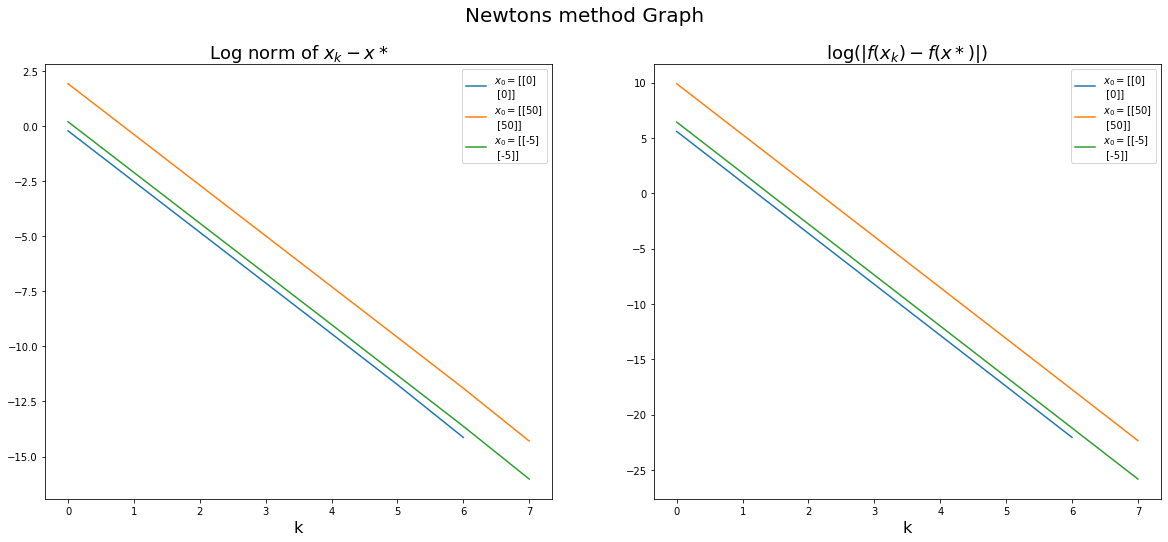

In [97]:
fig, ax = plt.subplots(1,2,figsize= (20,8))

for i in range(len(my_x)):
  log_norm = []
  log_norm_fx = []

  for xk in x_iterates_nwtn[i]:
    log_norm.append(np.log(np.linalg.norm(xk - x_nwtn[i])))
    log_norm_fx.append(float(np.log(np.abs(  evalf(A,xk,y,p,n_sample,lamb) - evalf(A,x_nwtn[i],y,p,n_sample,lamb)          ))))


  fig.suptitle('Newtons method Graph', fontsize=20)
  ax[0].plot(np.arange(len(x_iterates_nwtn[i])),log_norm, label='$x_0=${}'.format(str(my_x[i]))    )
  ax[0].set_title('Log norm of $x_k - x*$', fontsize = 18)
  ax[0].set_xlabel('k', fontsize = 16)
  ax[0].legend()

  ax[1].plot(np.arange(len(x_iterates_nwtn[i])),log_norm_fx, label='$x_0=${}'.format(str(my_x[i]))  )
  ax[1].set_title('$\log(|f(x_k) - f(x*)|)$', fontsize = 18)
  ax[1].set_xlabel('k', fontsize = 16)
  ax[1].legend()



***Remarks :***  *We observe that the rate of convergence in the above graphs is linear and decreases as me increase the iteration, it means as we perform more and more iteration, our true value is achieved near optimal.*

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


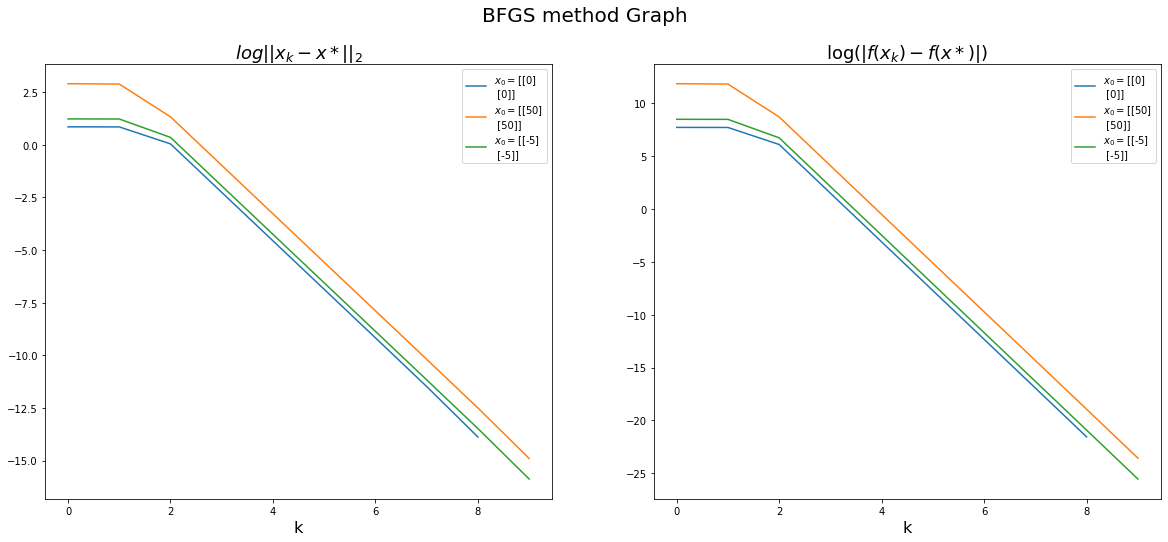

In [98]:
fig, ax = plt.subplots(1,2,figsize= (20,8))

for i in range(len(my_x)):
  log_norm = []
  log_norm_fx = []

  for xk in x_iterates_bfgs[i]:
    log_norm.append(np.log(np.linalg.norm(xk - x_bfgs[i])))
    log_norm_fx.append(float(np.log(np.abs(  evalf(A,xk,y,p,n_sample,lamb) - evalf(A,x_bfgs[i],y,p,n_sample,lamb)          ))))


  fig.suptitle('BFGS method Graph', fontsize=20)
  ax[0].plot(np.arange(len(x_iterates_bfgs[i])),log_norm, label='$x_0=${}'.format(str(my_x[i]))    )
  ax[0].set_title('$log||x_k - x*||_2$', fontsize = 18)
  ax[0].set_xlabel('k', fontsize = 16)
  ax[0].legend()

  ax[1].plot(np.arange(len(x_iterates_bfgs[i])),log_norm_fx, label='$x_0=${}'.format(str(my_x[i]))  )
  ax[1].set_title('$\log(|f(x_k) - f(x*)|)$', fontsize = 18)
  ax[1].set_xlabel('k', fontsize = 16)
  ax[1].legend()



***Remarks :***  *We observe that the rate of convergence in the above graphs is Q -linear and decreases as me increase the iteration, it means as we perform more and more iteration, our true value is achieved near optimal.*

### $\textbf{Part 4 : Changing the values of $\lambda$ and repeating the process in part 3}$

In [99]:
my_x = np.array([0,0]).reshape((2, 1)) 
my_tol = 10e-5
alpha = 0.9
rho = 0.5
gamma = 0.5
lamb_arr = [10e-3 , 10e-1, 1.0 ,10.0 , 100.0]

x_nwtn = []
x_bfgs= []
x_iterates_nwtn = []
x_iterates_bfgs = []

for lamb in lamb_arr:
  a_n, b_n, c_n  = find_minimizer_Newtonmethod(A,my_x,y,p,n_sample,lamb,my_tol,BACKTRACKING_LINE_SEARCH,alpha,rho,gamma)
  x_nwtn.append(a_n)
  x_iterates_nwtn.append(c_n)

  a_b, b_b, c_b = find_minimizer_BFGS(A,my_x,y,p,n_sample,lamb,my_tol,BACKTRACKING_LINE_SEARCH,alpha,rho,gamma)
  x_bfgs.append(a_b)
  x_iterates_bfgs.append(c_b)



dic = {'$\lambda$' : lamb_arr , 'x_bar' : [x_bar for j in range(len(lamb_arr))],'X_optimal_Nwtn' : x_nwtn , 'F(x)_optimal_Nwtn' : [evalf(A,my_x,y,p,n_sample,lamb) for lamb in lamb_arr] , 'Iterations_Nwtn' : [len(x_iterates_nwtn[j]) for j in range(len(lamb_arr))] }
df = pd.DataFrame(dic)
display(df)

print('\n\n')

dic2 = {'$\lambda$' : lamb_arr , 'x_bar' : [x_bar for j in range(len(lamb_arr))],'X_optimal_bfgs' : x_bfgs , 'F(x)_optimal_bfgs' : [evalf(A,my_x,y,p,n_sample,lamb) for lamb in lamb_arr] , 'Iterations_bfgs' : [len(x_iterates_bfgs[j]) for j in range(len(lamb_arr))] }
df2 = pd.DataFrame(dic2)
df2





,$\lambda$,x_bar,X_optimal_Nwtn,F(x)_optimal_Nwtn,Iterations_Nwtn
0,0.01,"[[-3.7764178534330535], [7.17359240073729]]","[[-3.7689764899382356], [7.165979572800758]]",[[26624.69387192216]],8
1,1.00,"[[-3.7764178534330535], [7.17359240073729]]","[[-3.7643235563275175], [7.157234396564945]]",[[26624.69387192216]],8
2,1.00,"[[-3.7764178534330535], [7.17359240073729]]","[[-3.7643235563275175], [7.157234396564945]]",[[26624.69387192216]],8
3,10.00,"[[-3.7764178534330535], [7.17359240073729]]","[[-3.7225450767937414], [7.078701185228701]]",[[26624.69387192216]],8
4,100.00,"[[-3.7764178534330535], [7.17359240073729]]","[[-3.3506566620811458], [6.378791849537861]]",[[26624.69387192216]],8


,$\lambda$,x_bar,X_optimal_bfgs,F(x)_optimal_bfgs,Iterations_bfgs
0,0.01,"[[-3.7764178534330535], [7.17359240073729]]","[[-3.768976479622315], [7.165979552310772]]",[[26624.69387192216]],10
1,1.00,"[[-3.7764178534330535], [7.17359240073729]]","[[-3.764323546012924], [7.157234375909245]]",[[26624.69387192216]],10
2,1.00,"[[-3.7764178534330535], [7.17359240073729]]","[[-3.764323546012924], [7.157234375909245]]",[[26624.69387192216]],10
3,10.00,"[[-3.7764178534330535], [7.17359240073729]]","[[-3.7225450665369175], [7.078701163225488]]",[[26624.69387192216]],10
4,100.00,"[[-3.7764178534330535], [7.17359240073729]]","[[-3.3506566746125395], [6.378791876711715]]",[[26624.69387192216]],10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: 

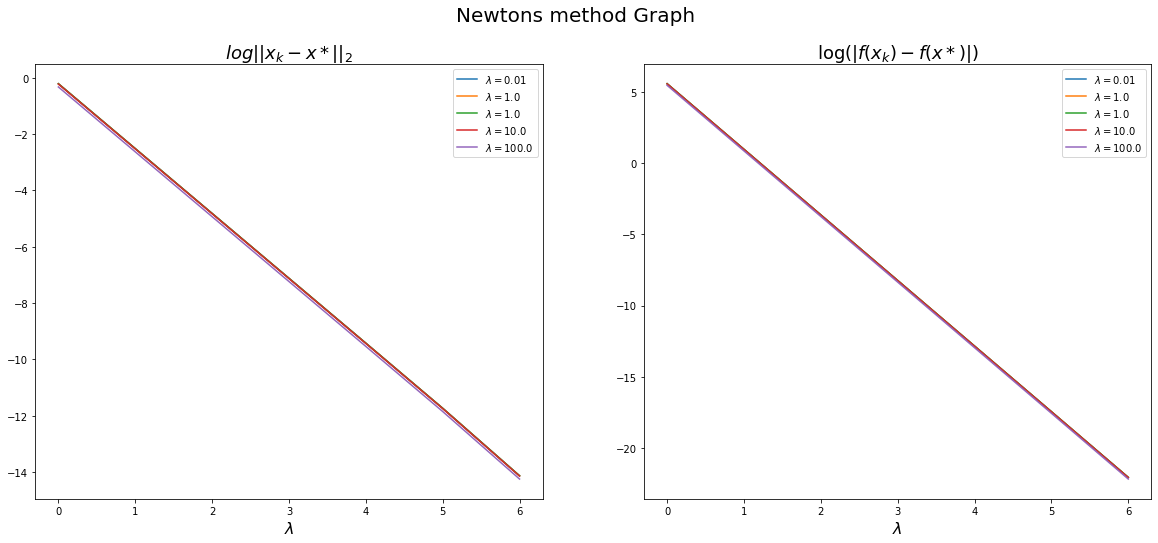

In [100]:
fig, axe = plt.subplots(1,2,figsize= (20,8))

for i in range(len(lamb_arr)):

  log_norm = []
  log_norm_fx = []

  for xk in x_iterates_nwtn[i]:
    log_norm.append(np.log(np.linalg.norm(xk - x_nwtn[i])))
    log_norm_fx.append(float(np.log(np.abs(  evalf(A,xk,y,p,n_sample,lamb_arr[i]) - evalf(A,x_nwtn[i],y,p,n_sample,lamb_arr[i])          ))))


  fig.suptitle('Newtons method Graph', fontsize=20)
  axe[0].plot(np.arange(len(x_iterates_nwtn[i])),log_norm, label='$\lambda =${}'.format(lamb_arr[i])    )
  axe[0].set_title('$log||x_k - x*||_2$', fontsize = 18)
  axe[0].set_xlabel('$\lambda$', fontsize = 16)
  axe[0].legend()


  axe[1].plot(np.arange(len(x_iterates_nwtn[i])),log_norm_fx, label='$\lambda =${}'.format(lamb_arr[i])  )
  axe[1].set_title('$\log(|f(x_k) - f(x*)|)$', fontsize = 18)
  axe[1].set_xlabel('$ \lambda $', fontsize = 16)
  axe[1].legend()



***Remarks :***  *We observe that the rate of convergence in the above graphs has almost no effect on changing the value of $\lambda$. There is no significant difference on the convergence of the solution by changing lambda and hecnce all the lines are appproximately equal to each other and overlap..*

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: 

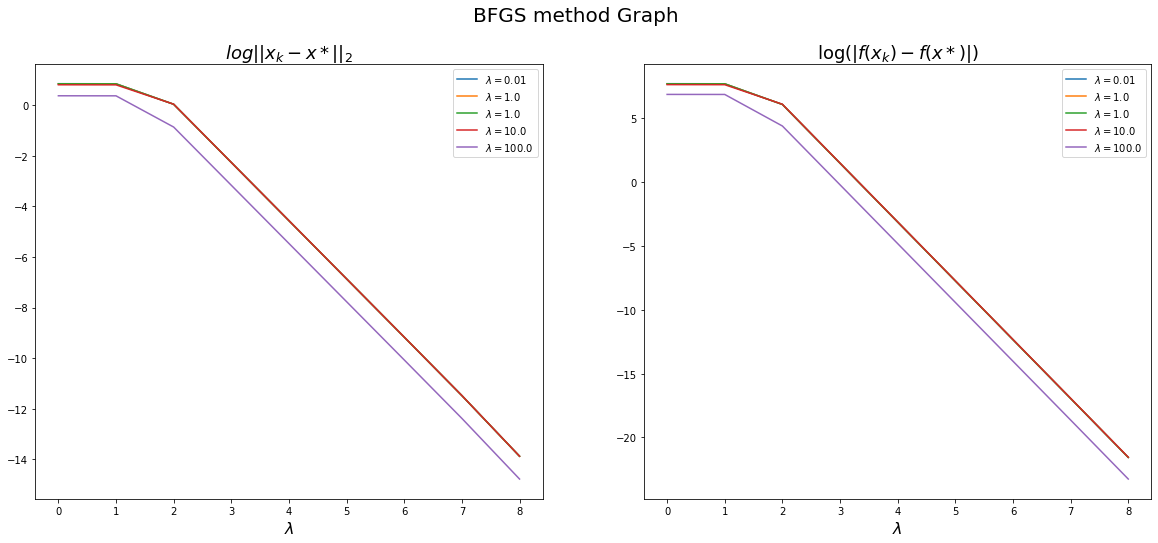

In [101]:
fig, axe = plt.subplots(1,2,figsize= (20,8))

for i in range(len(lamb_arr)):

  log_norm = []
  log_norm_fx = []

  for xk in x_iterates_bfgs[i]:
    log_norm.append(np.log(np.linalg.norm(xk - x_bfgs[i])))
    log_norm_fx.append(float(np.log(np.abs(  evalf(A,xk,y,p,n_sample,lamb_arr[i]) - evalf(A,x_bfgs[i],y,p,n_sample,lamb_arr[i])          ))))


  fig.suptitle('BFGS method Graph', fontsize=20)
  axe[0].plot(np.arange(len(x_iterates_bfgs[i])),log_norm, label='$\lambda =${}'.format(lamb_arr[i])    )
  axe[0].set_title('$log||x_k - x*||_2$', fontsize = 18)
  axe[0].set_xlabel('$\lambda$', fontsize = 16)
  axe[0].legend()


  axe[1].plot(np.arange(len(x_iterates_bfgs[i])),log_norm_fx, label='$\lambda =${}'.format(lamb_arr[i])  )
  axe[1].set_title('$\log(|f(x_k) - f(x*)|)$', fontsize = 18)
  axe[1].set_xlabel('$ \lambda $', fontsize = 16)
  axe[1].legend()



***Remarks :***  *We observe that the rate of convergence in the above graphs has almost no effect on changing the value of $\lambda$. There is no significant difference on the convergence of the solution by changing lambda and hecnce all the lines are appproximately equal to each other and overlap. *

*Only when the value of $\lambda = 100$, the grapgh is shifted below other, indicating that for $\lambda = 100$ the solution is converging faster since for such a high value of lambda, the cost associated with increasing the value of x is very high.*

### $\textbf{Part 5: Changing the data and repeating part 4}$

Sample size : n = 2400

In [102]:
p = 2
n_sample = 2400

A = random.randn(n_sample, p)
x_bar = np.zeros((p,1))

x_bar[0] = random.uniform(-4.0, -2.0)
x_bar[1] = random.uniform(6.0, 8.0)

e = random.rand(n_sample, 1)
y = np.matmul(A,x_bar) + e



In [103]:
my_x = np.array([0,0]).reshape((2, 1)) 
my_tol = 10e-5
alpha = 0.9
rho = 0.5
gamma = 0.5
lamb_arr = [10e-3 , 10e-1, 1.0 ,10.0 , 100.0]

x_nwtn = []
x_bfgs= []
x_iterates_nwtn = []
x_iterates_bfgs = []
time_nwtn = []
time_bfgs = []

for lamb in lamb_arr:

  t_start = timer()
  a_n, b_n, c_n  = find_minimizer_Newtonmethod(A,my_x,y,p,n_sample,lamb,my_tol,BACKTRACKING_LINE_SEARCH,alpha,rho,gamma)
  t_end = timer()
  time_nwtn.append(t_end - t_start)

  x_nwtn.append(a_n)
  x_iterates_nwtn.append(c_n)

  t_start = timer()
  a_b, b_b, c_b = find_minimizer_BFGS(A,my_x,y,p,n_sample,lamb,my_tol,BACKTRACKING_LINE_SEARCH,alpha,rho,gamma)
  t_end = timer()
  time_bfgs.append(t_end - t_start)
  x_bfgs.append(a_b)
  x_iterates_bfgs.append(c_b)



dic = {'$\lambda$' : lamb_arr , 'x_bar' : [x_bar for j in range(len(lamb_arr))],'X_optimal_Nwtn' : x_nwtn , 'F(x)_optimal_Nwtn' : [evalf(A,my_x,y,p,n_sample,lamb) for lamb in lamb_arr] , 'Iterations_Nwtn' : [len(x_iterates_nwtn[j]) for j in range(len(lamb_arr))] , 'time' : time_nwtn }
df = pd.DataFrame(dic)
display(df)

print('\n\n')

dic2 = {'$\lambda$' : lamb_arr , 'x_bar' : [x_bar for j in range(len(lamb_arr))],'X_optimal_bfgs' : x_bfgs , 'F(x)_optimal_bfgs' : [evalf(A,my_x,y,p,n_sample,lamb) for lamb in lamb_arr] , 'Iterations_bfgs' : [len(x_iterates_bfgs[j]) for j in range(len(lamb_arr))] , 'time' : time_bfgs }
df2 = pd.DataFrame(dic2)
df2





,$\lambda$,x_bar,X_optimal_Nwtn,F(x)_optimal_Nwtn,Iterations_Nwtn,time
0,0.01,"[[-2.2185408780665394], [6.9985670083061855]]","[[-2.2243373243152162], [6.986695529690855]]",[[68423.716731024]],9,0.002784
1,1.00,"[[-2.2185408780665394], [6.9985670083061855]]","[[-2.223479781026346], [6.983959698312334]]",[[68423.716731024]],9,0.004644
2,1.00,"[[-2.2185408780665394], [6.9985670083061855]]","[[-2.223479781026346], [6.983959698312334]]",[[68423.716731024]],9,0.001912
3,10.00,"[[-2.2185408780665394], [6.9985670083061855]]","[[-2.2157141246175445], [6.9591864404749915]]",[[68423.716731024]],9,0.001841
4,100.00,"[[-2.2185408780665394], [6.9985670083061855]]","[[-2.140937576908937], [6.720789831694659]]",[[68423.716731024]],9,0.001838


,$\lambda$,x_bar,X_optimal_bfgs,F(x)_optimal_bfgs,Iterations_bfgs,time
0,0.01,"[[-2.2185408780665394], [6.9985670083061855]]","[[-2.2243373230897068], [6.986695526176616]]",[[68423.716731024]],11,0.005167
1,1.00,"[[-2.2185408780665394], [6.9985670083061855]]","[[-2.2234797797984465], [6.9839596947951765]]",[[68423.716731024]],11,0.005972
2,1.00,"[[-2.2185408780665394], [6.9985670083061855]]","[[-2.2234797797984465], [6.9839596947951765]]",[[68423.716731024]],11,0.004678
3,10.00,"[[-2.2185408780665394], [6.9985670083061855]]","[[-2.215714123368129], [6.959186436931609]]",[[68423.716731024]],11,0.004604
4,100.00,"[[-2.2185408780665394], [6.9985670083061855]]","[[-2.140937575465216], [6.720789827920461]]",[[68423.716731024]],11,0.004592


***Remarks :***  *We observe that the *the optimal value and the value of the function is almost same for all values of lambda. The computational time to calculate the optimal value of x always does not vary much across different values of lambda. The number of iterations in BFGS is more than newtons methods. A similar pattern that we have also observed in previous part.*



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: 

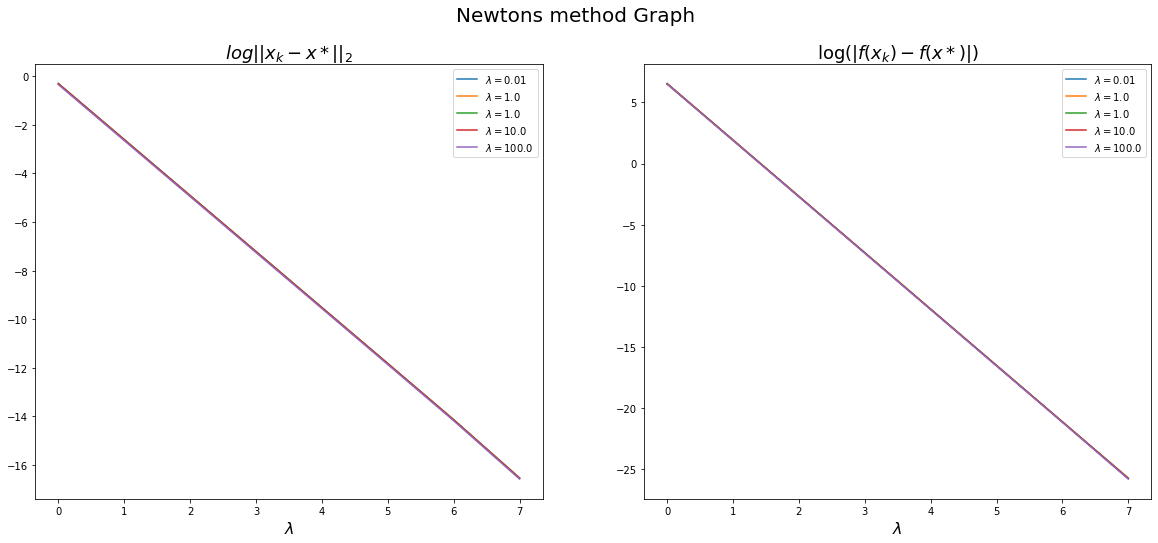

In [104]:
fig, axe = plt.subplots(1,2,figsize= (20,8))

for i in range(len(lamb_arr)):

  log_norm = []
  log_norm_fx = []

  for xk in x_iterates_nwtn[i]:
    log_norm.append(np.log(np.linalg.norm(xk - x_nwtn[i])))
    log_norm_fx.append(float(np.log(np.abs(  evalf(A,xk,y,p,n_sample,lamb_arr[i]) - evalf(A,x_nwtn[i],y,p,n_sample,lamb_arr[i])          ))))


  fig.suptitle('Newtons method Graph', fontsize=20)
  axe[0].plot(np.arange(len(x_iterates_nwtn[i])),log_norm, label='$\lambda =${}'.format(lamb_arr[i])    )
  axe[0].set_title('$log||x_k - x*||_2$', fontsize = 18)
  axe[0].set_xlabel('$\lambda$', fontsize = 16)
  axe[0].legend()


  axe[1].plot(np.arange(len(x_iterates_nwtn[i])),log_norm_fx, label='$\lambda =${}'.format(lamb_arr[i])  )
  axe[1].set_title('$\log(|f(x_k) - f(x*)|)$', fontsize = 18)
  axe[1].set_xlabel('$ \lambda $', fontsize = 16)
  axe[1].legend()



***Remarks :***  *We observe that the rate of convergence in the above graphs has almost no effect on changing the value of $\lambda$. There is no significant difference on the convergence of the solution by changing lambda and hecnce all the lines are appproximately equal to each other and overlap..*

*We see that increasing the size of the sample has reduced the variance of the lines from earlier data. Now we can be more sure that data does not show any improvement in changing the values of the lambda.*

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: 

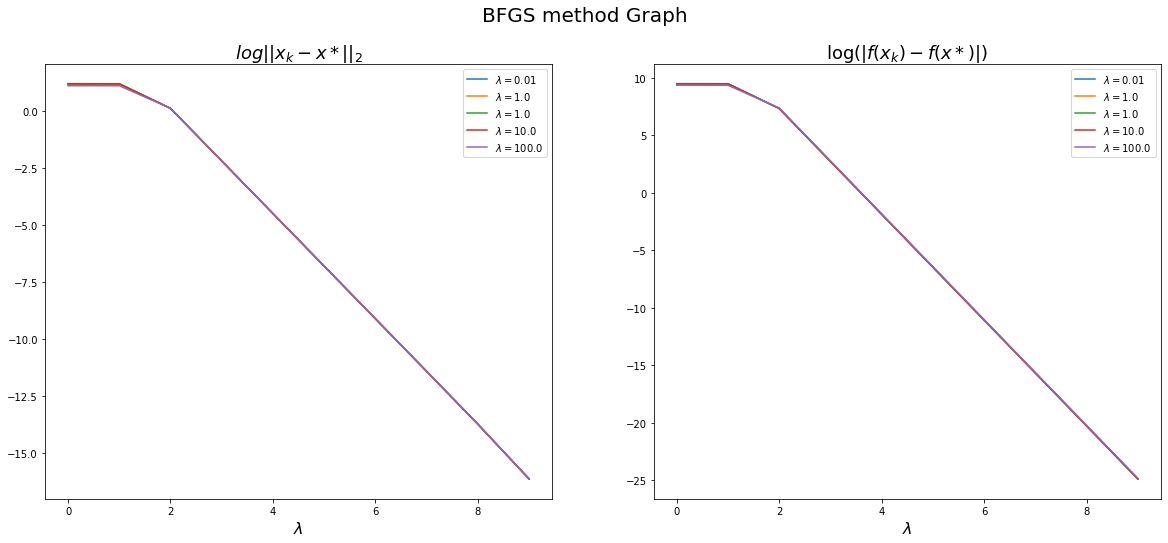

In [105]:
fig, axe = plt.subplots(1,2,figsize= (20,8))

for i in range(len(lamb_arr)):

  log_norm = []
  log_norm_fx = []

  for xk in x_iterates_bfgs[i]:
    log_norm.append(np.log(np.linalg.norm(xk - x_bfgs[i])))
    log_norm_fx.append(float(np.log(np.abs(  evalf(A,xk,y,p,n_sample,lamb_arr[i]) - evalf(A,x_bfgs[i],y,p,n_sample,lamb_arr[i])          ))))


  fig.suptitle('BFGS method Graph', fontsize=20)
  axe[0].plot(np.arange(len(x_iterates_bfgs[i])),log_norm, label='$\lambda =${}'.format(lamb_arr[i])    )
  axe[0].set_title('$log||x_k - x*||_2$', fontsize = 18)
  axe[0].set_xlabel('$\lambda$', fontsize = 16)
  axe[0].legend()


  axe[1].plot(np.arange(len(x_iterates_bfgs[i])),log_norm_fx, label='$\lambda =${}'.format(lamb_arr[i])  )
  axe[1].set_title('$\log(|f(x_k) - f(x*)|)$', fontsize = 18)
  axe[1].set_xlabel('$ \lambda $', fontsize = 16)
  axe[1].legend()



***Remarks :***  *Similar effect is clearly visible in BFGS method also. The variance of the lines is reduces by a great level when we increase the size of our sample and hence increasing the value of lambda has no effect calculating the optimal value of x.*

### $\textbf{Part 6: Changing the data and repeating part 5}$

Sample size : n = 9600

In [106]:
p = 2
n_sample = 9600

A = random.randn(n_sample, p)
x_bar = np.zeros((p,1))

x_bar[0] = random.uniform(-4.0, -2.0)
x_bar[1] = random.uniform(6.0, 8.0)

e = random.rand(n_sample, 1)
y = np.matmul(A,x_bar) + e



In [107]:
my_x = np.array([0,0]).reshape((2, 1)) 
my_tol = 10e-5
alpha = 0.9
rho = 0.5
gamma = 0.5
lamb_arr = [10e-3 , 10e-1, 1.0 ,10.0 , 100.0]

x_nwtn = []
x_bfgs= []
x_iterates_nwtn = []
x_iterates_bfgs = []
time_nwtn = []
time_bfgs = []

for lamb in lamb_arr:

  t_start = timer()
  a_n, b_n, c_n  = find_minimizer_Newtonmethod(A,my_x,y,p,n_sample,lamb,my_tol,BACKTRACKING_LINE_SEARCH,alpha,rho,gamma)
  t_end = timer()
  time_nwtn.append(t_end - t_start)

  x_nwtn.append(a_n)
  x_iterates_nwtn.append(c_n)

  t_start = timer()
  a_b, b_b, c_b = find_minimizer_BFGS(A,my_x,y,p,n_sample,lamb,my_tol,BACKTRACKING_LINE_SEARCH,alpha,rho,gamma)
  t_end = timer()
  time_bfgs.append(t_end - t_start)
  x_bfgs.append(a_b)
  x_iterates_bfgs.append(c_b)



dic = {'$\lambda$' : lamb_arr , 'x_bar' : [x_bar for j in range(len(lamb_arr))],'X_optimal_Nwtn' : x_nwtn , 'F(x)_optimal_Nwtn' : [evalf(A,my_x,y,p,n_sample,lamb) for lamb in lamb_arr] , 'Iterations_Nwtn' : [len(x_iterates_nwtn[j]) for j in range(len(lamb_arr))] , 'time' : time_nwtn }
df = pd.DataFrame(dic)
display(df)

print('\n\n')

dic2 = {'$\lambda$' : lamb_arr , 'x_bar' : [x_bar for j in range(len(lamb_arr))],'X_optimal_bfgs' : x_bfgs , 'F(x)_optimal_bfgs' : [evalf(A,my_x,y,p,n_sample,lamb) for lamb in lamb_arr] , 'Iterations_bfgs' : [len(x_iterates_bfgs[j]) for j in range(len(lamb_arr))] , 'time' : time_bfgs }
df2 = pd.DataFrame(dic2)
df2





,$\lambda$,x_bar,X_optimal_Nwtn,F(x)_optimal_Nwtn,Iterations_Nwtn,time
0,0.01,"[[-2.466222386775501], [6.867776644045172]]","[[-2.472191127952752], [6.8643373079526055]]",[[258581.1991427573]],9,0.003266
1,1.00,"[[-2.466222386775501], [6.867776644045172]]","[[-2.471937361167659], [6.863633650518272]]",[[258581.1991427573]],9,0.002959
2,1.00,"[[-2.466222386775501], [6.867776644045172]]","[[-2.471937361167659], [6.863633650518272]]",[[258581.1991427573]],9,0.002966
3,10.00,"[[-2.466222386775501], [6.867776644045172]]","[[-2.469632777782692], [6.857243375591233]]",[[258581.1991427573]],9,0.003034
4,100.00,"[[-2.466222386775501], [6.867776644045172]]","[[-2.446821104053985], [6.793989040587965]]",[[258581.1991427573]],9,0.002985


,$\lambda$,x_bar,X_optimal_bfgs,F(x)_optimal_bfgs,Iterations_bfgs,time
0,0.01,"[[-2.466222386775501], [6.867776644045172]]","[[-2.4721911277072848], [6.864337311074575]]",[[258581.1991427573]],11,0.007178
1,1.00,"[[-2.466222386775501], [6.867776644045172]]","[[-2.4719373609222957], [6.863633653636603]]",[[258581.1991427573]],11,0.007090
2,1.00,"[[-2.466222386775501], [6.867776644045172]]","[[-2.4719373609222957], [6.863633653636603]]",[[258581.1991427573]],11,0.007640
3,10.00,"[[-2.466222386775501], [6.867776644045172]]","[[-2.4696327775382656], [6.857243378676533]]",[[258581.1991427573]],11,0.007057
4,100.00,"[[-2.466222386775501], [6.867776644045172]]","[[-2.446821103818226], [6.793989043347395]]",[[258581.1991427573]],11,0.007113


***Remarks :***  *We observe that the *the optimal value and the value of the function is almost same for all values of lambda. The computational time to calculate the optimal value of x always does not vary much across different values of lambda. The number of iterations in BFGS is more than newtons methods. A similar pattern that we have also observed in previous part.*



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: 

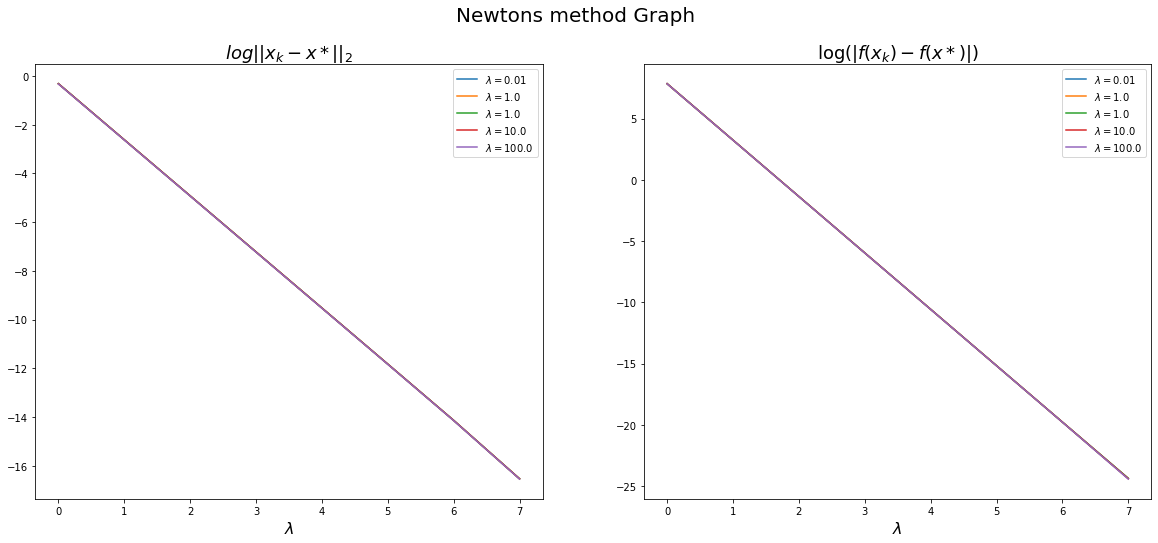

In [108]:
fig, axe = plt.subplots(1,2,figsize= (20,8))

for i in range(len(lamb_arr)):

  log_norm = []
  log_norm_fx = []

  for xk in x_iterates_nwtn[i]:
    log_norm.append(np.log(np.linalg.norm(xk - x_nwtn[i])))
    log_norm_fx.append(float(np.log(np.abs(  evalf(A,xk,y,p,n_sample,lamb_arr[i]) - evalf(A,x_nwtn[i],y,p,n_sample,lamb_arr[i])          ))))


  fig.suptitle('Newtons method Graph', fontsize=20)
  axe[0].plot(np.arange(len(x_iterates_nwtn[i])),log_norm, label='$\lambda =${}'.format(lamb_arr[i])    )
  axe[0].set_title('$log||x_k - x*||_2$', fontsize = 18)
  axe[0].set_xlabel('$\lambda$', fontsize = 16)
  axe[0].legend()


  axe[1].plot(np.arange(len(x_iterates_nwtn[i])),log_norm_fx, label='$\lambda =${}'.format(lamb_arr[i])  )
  axe[1].set_title('$\log(|f(x_k) - f(x*)|)$', fontsize = 18)
  axe[1].set_xlabel('$ \lambda $', fontsize = 16)
  axe[1].legend()



***Remarks :***  *We observe that the rate of convergence in the above graphs has almost no effect on changing the value of $\lambda$. There is no significant difference on the convergence of the solution by changing lambda and hecnce all the lines are appproximately equal to each other and overlap..*

*We see that increasing the size of the sample has reduced the variance of the lines from earlier data. Now we can be more sure that data does not show any improvement in changing the values of the lambda.*

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: 

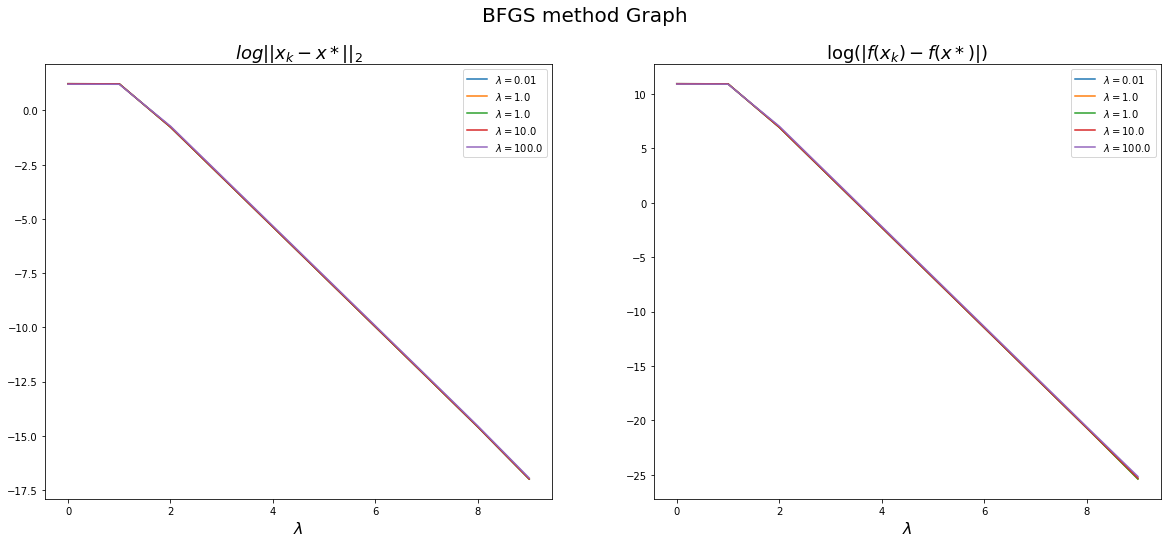

In [109]:
fig, axe = plt.subplots(1,2,figsize= (20,8))

for i in range(len(lamb_arr)):

  log_norm = []
  log_norm_fx = []

  for xk in x_iterates_bfgs[i]:
    log_norm.append(np.log(np.linalg.norm(xk - x_bfgs[i])))
    log_norm_fx.append(float(np.log(np.abs(  evalf(A,xk,y,p,n_sample,lamb_arr[i]) - evalf(A,x_bfgs[i],y,p,n_sample,lamb_arr[i])          ))))


  fig.suptitle('BFGS method Graph', fontsize=20)
  axe[0].plot(np.arange(len(x_iterates_bfgs[i])),log_norm, label='$\lambda =${}'.format(lamb_arr[i])    )
  axe[0].set_title('$log||x_k - x*||_2$', fontsize = 18)
  axe[0].set_xlabel('$\lambda$', fontsize = 16)
  axe[0].legend()


  axe[1].plot(np.arange(len(x_iterates_bfgs[i])),log_norm_fx, label='$\lambda =${}'.format(lamb_arr[i])  )
  axe[1].set_title('$\log(|f(x_k) - f(x*)|)$', fontsize = 18)
  axe[1].set_xlabel('$ \lambda $', fontsize = 16)
  axe[1].legend()



***Remarks :***  *Similar effect is clearly visible in BFGS method also. The variance of the lines is reduces by a great level when we increase the size of our sample and hence increasing the value of lambda has no effect calculating the optimal value of x.*


### $\textbf{Part 7: Computational Time }$

*The computanional time increases when we increase the size of the data matrix A. When the size of the sample was 2400, the approx time taken by the algorithm was 0.002 and 0.0045 using newtons and bfgs methods respectively. But when we increase the size of the data to 9600 the times taken by newtons method and bfgs methods were 0.003 and 0.0075.*

*Time for the newtons method does not change much but in the bfgs method there is a significant amount of cahnge in the time.*

